# Анализ поведения пользователей мобильного приложения

Компания-стартап продает продукты питания через мобильное приложение. 

**Цель** - изучить поведение пользователей в мобильном приложении.

**Задачи**:
- Загрузить и подготовить данные к анализу;
- Создать воронку продаж, изучить движение покупателей по всем шагам воронки;
- Изучить группы А/А/В теста;
- Посмотреть, влияет ли изменение шрифта на поведение пользователей на разных шагах воронки продаж;
- Сформулировать выводы;

**Описание данных**

Файл /datasets/logs_exp.csv:

    EventName — название события;
    DeviceIDHash — уникальный идентификатор пользователя;
    EventTimestamp — время события;
    ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Загрузка и подготовка данных

In [77]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as st
from plotly import graph_objects as go 
import math as mth

In [78]:
try:
    df = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
except:
    df = pd.read_csv('logs_exp.csv', sep='\t')

In [79]:
def check(df):
    df.info()
    display(df.head(5))
    print('Количество пропусков:', df.isnull().sum())
    print('Количество дубликатов:', df.duplicated().sum())

In [80]:
check(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Количество пропусков: EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64
Количество дубликатов: 413


In [81]:
print('Доля дубликатов:', df.duplicated().sum() / len(df))

Доля дубликатов: 0.0016917493425526163


In [82]:
df = df.drop_duplicates()
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       243713 non-null  object
 1   DeviceIDHash    243713 non-null  int64 
 2   EventTimestamp  243713 non-null  int64 
 3   ExpId           243713 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.4+ MB


In [83]:
df.columns = ['event_name', 'device_id_hash', 'event_timestamp', 'exp_id']
df.head(5)

,event_name,device_id_hash,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [84]:
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'], unit='s')

In [85]:
df['date'] = df['event_timestamp'].dt.date
df['date'] = df['date'].astype("datetime64[ns]")

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   device_id_hash   243713 non-null  int64         
 2   event_timestamp  243713 non-null  datetime64[ns]
 3   exp_id           243713 non-null  int64         
 4   date             243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


In [87]:
df.head(5)

,event_name,device_id_hash,event_timestamp,exp_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


Результаты изучения и подготовки данных к анализу:
- Пропусков не обнаружено;
- Найдены 413 дублей, после краткого изучения этих дублей принято решение их удалить;
- Переименованы столбцы датасета (перевод к "змеиному" регистру);
- Данные времени переведены из текстового формата во временной;
- Отдельно создан столбец с датами событий, тоже в формате времени;


## Анализ данных

In [88]:
df['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

In [89]:
print('Всего событий в логе:', df['event_name'].count())
print('Количество уникальных пользователей:', df['device_id_hash'].nunique())
print('Среднее количество событий на одного пользователя:', df['event_name'].count() / df['device_id_hash'].nunique())

Всего событий в логе: 243713
Количество уникальных пользователей: 7551
Среднее количество событий на одного пользователя: 32.27559263673685


In [90]:
df_users_acivity = df.groupby('device_id_hash').agg({'event_name': 'count'})
df_users_acivity.describe()

,event_name
count,7551.000000
mean,32.275593
std,65.154219
min,1.000000
25%,9.000000
50%,20.000000
75%,37.000000
max,2307.000000


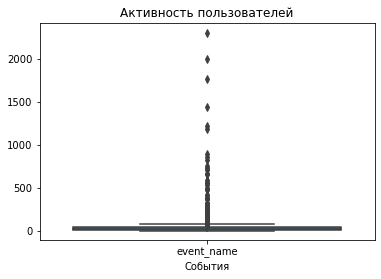

In [91]:
sns.boxplot(data = df_users_acivity)
plt.title('Активность пользователей');
plt.xlabel('События');


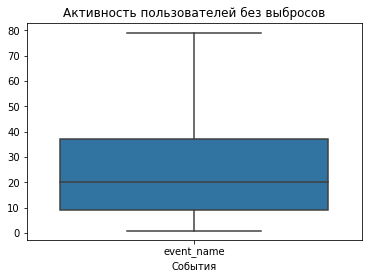

In [92]:
sns.boxplot(data = df_users_acivity, showfliers=False)
plt.title('Активность пользователей без выбросов');
plt.xlabel('События');


In [93]:
print('Количество аномальных пользователей:', df_users_acivity.query('event_name > 80').count())
print('Доля пользователей:', df_users_acivity.query('event_name > 80').count() / df_users_acivity.count())

Количество аномальных пользователей: event_name    483
dtype: int64
Доля пользователей: event_name    0.063965
dtype: float64


In [94]:
print('Время начала лога', df['event_timestamp'].min())
print('Время последнего события', df['event_timestamp'].max())

Время начала лога 2019-07-25 04:43:36
Время последнего события 2019-08-07 21:15:17


В логе данные до 7551 пользователи, которые в сумме совершили 243713 действий в период с 25 июля 2019 г. по 7 августа 2019 г. В среднем это 32.27 на пользователя. Также мы видим, что пользователи совершали 5 действий (Посещение главной страницы, Посещение страницы с оффером, Посещение страницы с оплатой, Посещение страницы с успешным проведением оплаты и наконец страницы с инструкцией.) События перечислены нами в порядке уменьшения количества действий на каждое событие. 483 пользователя (ок. 6,3%) являются аномальными - они совершали более 80 действий в указанный период.

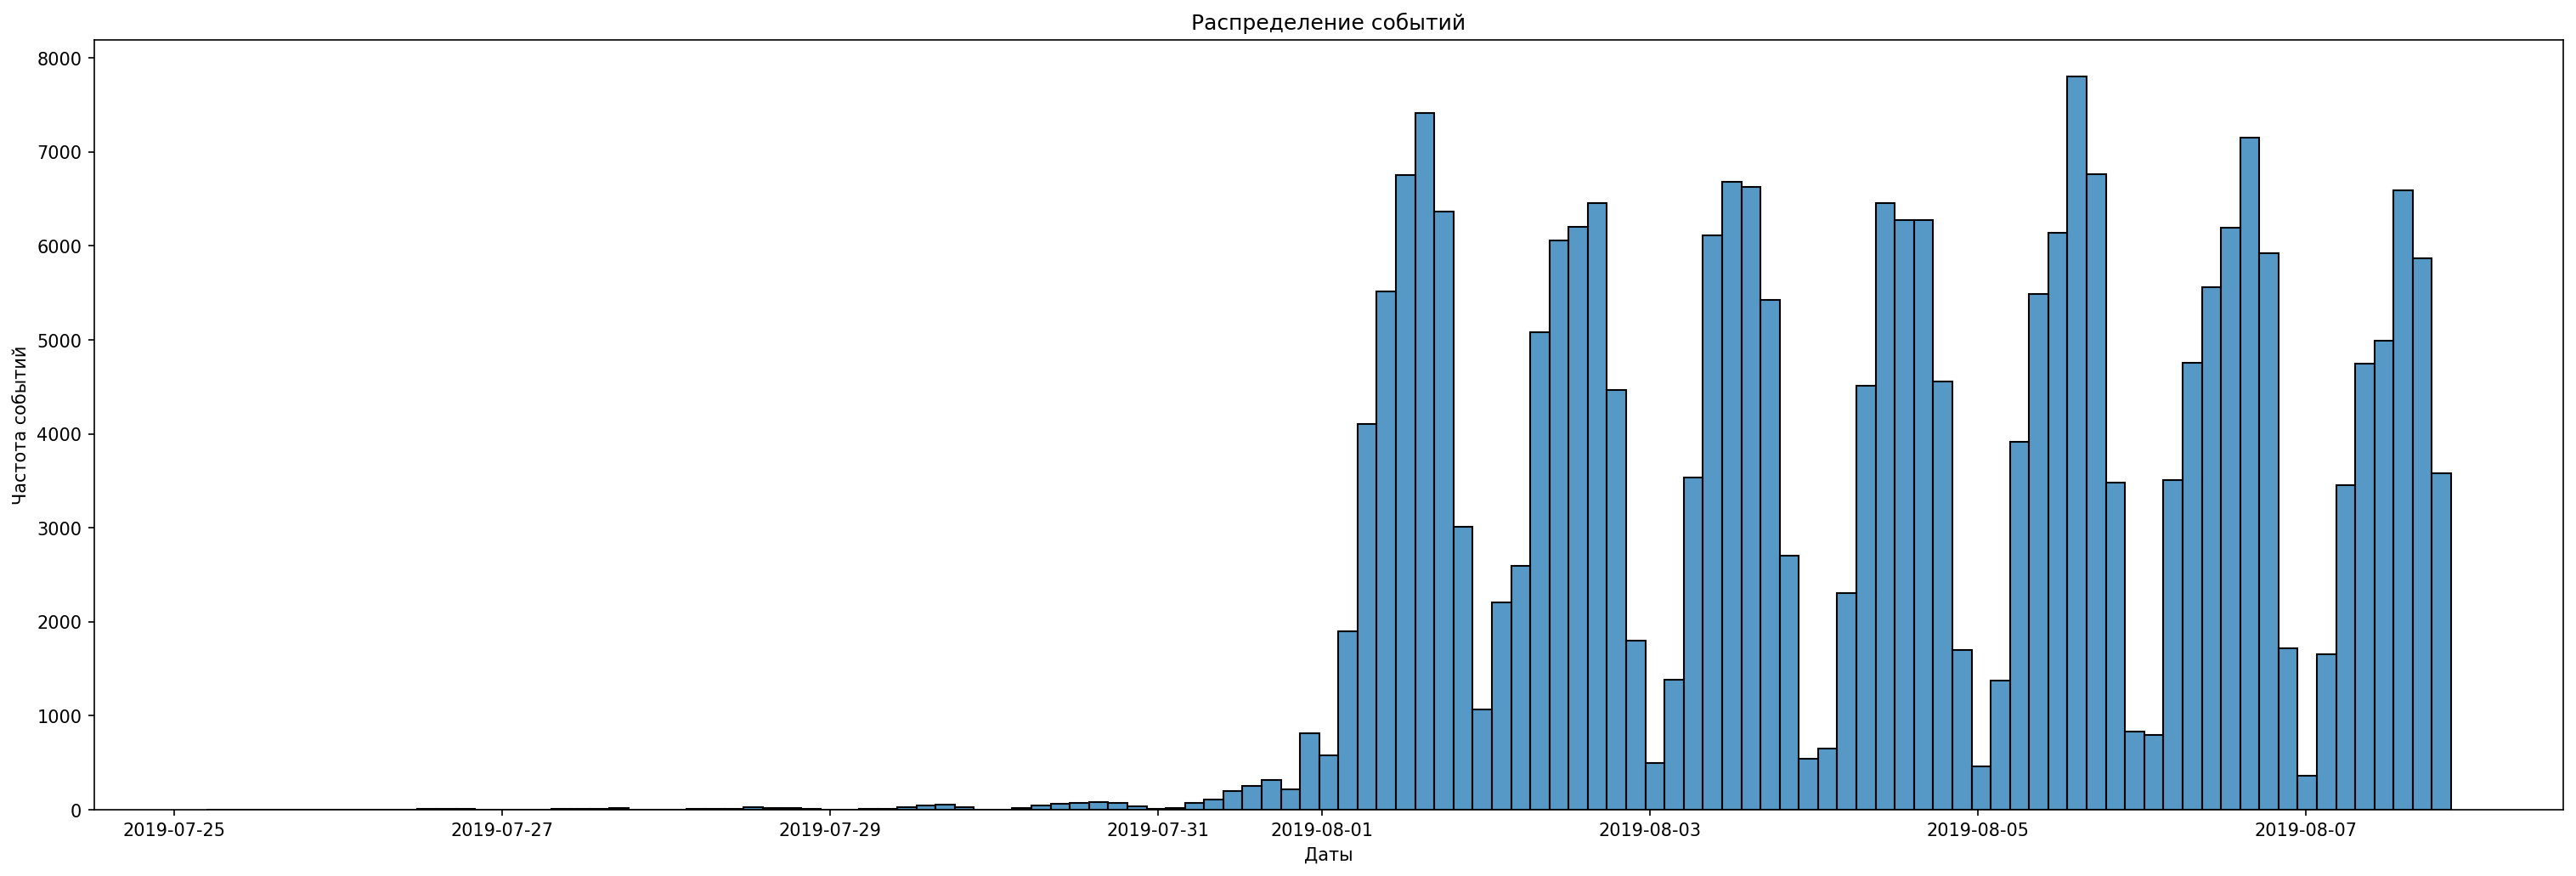

In [95]:
plt.figure(figsize=(25, 8), dpi=150)
sns.histplot(df['event_timestamp'])
plt.title('Распределение событий')
plt.xlabel('Даты')
plt.ylabel('Частота событий'); 

Гистограмма действий пользователей показывает, что бОльшая часть событий произошла после 1-го августа 2019. Волнообразность гистограммы объясняется временем суток. Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». 

Мы предлагаем брать данные с 1-го августа, причем в период с 09:00, чтобы отсечь данные, которые "доедут" с предыдущего периода (например, с вечера предыдущего дня или с ночи). Обычно такое происходит, когда телефон или планшет находятся вне зоны действия сети, и пачка событий приходит в один момент, причем позднее совершенного действия. 

Отфильтруем датасет по этой границе.

In [96]:
df_filtered = df.query('event_timestamp > "2019-08-01 09:00:00"')

In [97]:
print('Количество событий после изменения временного периода:', df_filtered['event_name'].count())
print('Количество отброшенных событий:', df['event_name'].count() - df_filtered['event_name'].count())
print('Доля отброшенных событий:', (df['event_name'].count() - df_filtered['event_name'].count()) / df['event_name'].count())
print('Количество уникальных пользователей после изменения временного периода:', df_filtered['device_id_hash'].nunique())
print('Количество отброшенных пользователей:', (df['device_id_hash'].nunique() - df_filtered['device_id_hash'].nunique()))
print('Доля отброшенных пользователей:', (df['device_id_hash'].nunique() - df_filtered['device_id_hash'].nunique()) / df['device_id_hash'].nunique())
print('Среднее количество событий на пользователя после изменения временного периода', df_filtered['event_name'].count() / df_filtered['device_id_hash'].nunique())


Количество событий после изменения временного периода: 232441
Количество отброшенных событий: 11272
Доля отброшенных событий: 0.04625112324742628
Количество уникальных пользователей после изменения временного периода: 7488
Количество отброшенных пользователей: 63
Доля отброшенных пользователей: 0.00834326579261025
Среднее количество событий на пользователя после изменения временного периода 31.041800213675213


In [98]:
df_filtered.groupby('exp_id').nunique().reset_index()

,exp_id,event_name,device_id_hash,event_timestamp,date
0,246,5,2465,63588,7
1,247,5,2500,62212,7
2,248,5,2523,68241,7


В каждой из трех групп у нас есть пользователи, числом от 2450 до 2503 человек.

## Анализ воронки событий

In [99]:
df_filtered['event_name'].value_counts()

MainScreenAppear           112056
OffersScreenAppear          44686
CartScreenAppear            41466
PaymentScreenSuccessful     33271
Tutorial                      962
Name: event_name, dtype: int64

In [100]:
event_grouped = df_filtered.groupby('event_name')\
    .agg({'device_id_hash':'nunique'})\
    .sort_values(by='device_id_hash', ascending=False) \
    .reset_index()

In [101]:
event_grouped.columns = ['event', 'users']

In [102]:
value_full = 7488
event_grouped['rate'] = event_grouped['users'] / value_full

In [103]:
event_grouped

,event,users,rate
0,MainScreenAppear,7367,0.983841
1,OffersScreenAppear,4552,0.607906
2,CartScreenAppear,3710,0.495459
3,PaymentScreenSuccessful,3515,0.469418
4,Tutorial,801,0.106971


Как было сказано выше, пользователи совершали 5 действий (Посещение главной страницы, Посещение страницы с оффером, Посещение страницы с оплатой, Посещение страницы с успешным проведением оплаты и наконец страницы с инструкцией.) События перечислены нами в порядке уменьшения количества действий на каждое событие. 

Порядок действий скорее всего совпадает с указанным за исключением посещения страницы с руководством, тк неясно, является ли оно обязательным на каком либо шаге (судя по количеству юзеров и действий - нет), и его "непопулярность" связана с тем, что на эту страницу пользователи идут не в рамках сценария покупки продуктов, а только в случае затруднений. Поэтому подробно изучать этот шаг мы не будем. 

Также мы посчитали количество юзеров на каждое событие и доли юзеров по отношению к первому шагу.

Построим воронку продаж

In [104]:
fig = go.Figure(
    go.Funnel(
        y=event_grouped.query('event != "Tutorial"')['event'],
        x=event_grouped.query('event != "Tutorial"')['users'],
    )
)
fig.update_layout(title="Воронка событий")
fig.show()

Больше всего пользователей мы теряем на втором шаге воронки (38,3% юзеров не доходят до страницы с оффером).
От первого события до оплаты доходит 47,7% юзеров из первого шага или 46,8% от общего количество юзеров из фильтрованного по времени датасета. Такая довольно высокая конверсия, вероятно, связана со спецификой работы магазина - на первую страницу попадают уже относительно мотивированные покупатели, и если уже они прошли страницу с оффером, то в дальнейшем от сделки отказывается небольшая часть юзеров. 

## Изучение результатов эксперимента

Посмотрим, сколько пользователей в каждой группе.

In [105]:
df_exp_groups = df_filtered.groupby('exp_id').nunique().reset_index()
df_exp_groups.columns = ['group_number', 'events', 'users', 'event_timestamp', 'date']

In [106]:
df_exp_groups

,group_number,events,users,event_timestamp,date
0,246,5,2465,63588,7
1,247,5,2500,62212,7
2,248,5,2523,68241,7


Проверим, есть ли пользователи, которые попали более, чем в одну экспериметальную группу.

In [107]:
bad_clients = df_filtered.groupby('device_id_hash') \
    .agg({'exp_id' : 'nunique'}) \
    .reset_index().query('exp_id>1')['device_id_hash']

In [108]:
bad_clients

Series([], Name: device_id_hash, dtype: int64)

Таких пользователей нет, соответственно, группы не пересекаются.

Посчитаем распределение пользователей всех трех групп по 5-ти событям. 

In [109]:
df_events_groups_2 = df_filtered.query('exp_id == 246').groupby('event_name').agg({'device_id_hash' : 'nunique'}).reset_index()

df_events_groups_3 = df_filtered.query('exp_id == 247').groupby('event_name').agg({'device_id_hash' : 'nunique'}).reset_index()

df_events_groups_4 = df_filtered.query('exp_id == 248').groupby('event_name').agg({'device_id_hash' : 'nunique'}).reset_index()

df_events_groups = df_events_groups_2.merge(df_events_groups_3, on='event_name', how='left')
df_events_groups = df_events_groups.merge(df_events_groups_4, on='event_name', how='left')

df_events_groups.columns = ['event_name', '246', '247', '248']

In [110]:
new_row_all = {'event_name':'all_users', '246':2450, '247':2480, '248':2503}

In [111]:
df_events_groups = df_events_groups.append(new_row_all, ignore_index=True)

In [112]:
df_events_groups.sort_values(by='246', ascending=False)

,event_name,246,247,248
5,all_users,2450,2480,2503
1,MainScreenAppear,2430,2463,2474
2,OffersScreenAppear,1528,1501,1523
0,CartScreenAppear,1260,1230,1220
3,PaymentScreenSuccessful,1193,1151,1171
4,Tutorial,265,269,267


Сравним контрольные группы (246 и 247)

H0 - между долями нет значимой разницы;

H1 - между долями есть значимая разница;

In [113]:
def check_hypothesis(successes1, successes2, trials1, trials2, alpha=0.01):
    # пропорция успехов в первой группе:
    p1 = successes1/trials1

    # пропорция успехов во второй группе:
    p2 = successes2/trials2

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes1 + successes2) / (trials1 + trials2)

    # разница пропорций в датасетах
    difference = p1 - p2
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))


    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

In [114]:
#MainScreenAppear
check_hypothesis(df_events_groups.loc[1, '246'],
                 df_events_groups.loc[1, '247'],
                 df_events_groups.loc[5, '246'],
                 df_events_groups.loc[5, '247'],
                )

p-значение:  0.5945718968689468
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [115]:
#OffersScreenAppear
check_hypothesis(df_events_groups.loc[2, '246'],
                 df_events_groups.loc[2, '247'],
                 df_events_groups.loc[5, '246'],
                 df_events_groups.loc[5, '247'],
                )

p-значение:  0.18371860954761843
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [116]:
#CartScreenAppear
check_hypothesis(df_events_groups.loc[0, '246'],
                 df_events_groups.loc[0, '247'],
                 df_events_groups.loc[5, '246'],
                 df_events_groups.loc[5, '247'],
                )

p-значение:  0.19836640012803985
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [117]:
#PaymentScreenSuccessful
check_hypothesis(df_events_groups.loc[3, '246'],
                 df_events_groups.loc[3, '247'],
                 df_events_groups.loc[5, '246'],
                 df_events_groups.loc[5, '247'],
                )

p-значение:  0.1085819644524586
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


При сравнении распределения пользователей двух контрольных групп по событиям во всемх случаях нам не удалось опровергнуть нулевую гипотезу. Это значит, что мы не можем статистически подтвердить разницу между двумя контрольными группами, а значит они подходят для проведения A/A/B эксперимента.

Сравним экспериментальную группу и первую контрольную группу (248 и 246)

In [118]:
#MainScreenAppear
check_hypothesis(df_events_groups.loc[1, '246'],
                 df_events_groups.loc[1, '248'],
                 df_events_groups.loc[5, '246'],
                 df_events_groups.loc[5, '248'],
                )

p-значение:  0.22363696254782295
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [119]:
#OffersScreenAppear
check_hypothesis(df_events_groups.loc[2, '246'],
                 df_events_groups.loc[2, '248'],
                 df_events_groups.loc[5, '246'],
                 df_events_groups.loc[5, '248'],
                )

p-значение:  0.27135864218610783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [120]:
#CartScreenAppear
check_hypothesis(df_events_groups.loc[0, '246'],
                 df_events_groups.loc[0, '248'],
                 df_events_groups.loc[2, '246'],
                 df_events_groups.loc[2, '248'],
                )

p-значение:  0.09530919638710689
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [121]:
#PaymentScreenSuccessful
check_hypothesis(df_events_groups.loc[3, '246'],
                 df_events_groups.loc[3, '248'],
                 df_events_groups.loc[5, '246'],
                 df_events_groups.loc[5, '248'],
                )

p-значение:  0.17845215445196194
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


При сравнении распределения пользователей первой контрольной группы и экспериментальной группы во всех случаях нам не удалось опровергнуть нулевую гипотезу. Это значит, что мы не можем статистически подтвердить разницу между этими группами.

Сравним экспериментальную группу и вторую контрольную группу (248 и 247)

In [122]:
#MainScreenAppear
check_hypothesis(df_events_groups.loc[1, '247'],
                 df_events_groups.loc[1, '248'],
                 df_events_groups.loc[5, '247'],
                 df_events_groups.loc[5, '248'],
                )

p-значение:  0.08079445286479436
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [123]:
#OffersScreenAppear
check_hypothesis(df_events_groups.loc[2, '247'],
                 df_events_groups.loc[2, '248'],
                 df_events_groups.loc[5, '247'],
                 df_events_groups.loc[5, '248'],
                )

p-значение:  0.8155705711748202
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [124]:
#CartScreenAppear
check_hypothesis(df_events_groups.loc[0, '247'],
                 df_events_groups.loc[0, '248'],
                 df_events_groups.loc[5, '247'],
                 df_events_groups.loc[5, '248'],
                )

p-значение:  0.5459690778262263
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [125]:
#PaymentScreenSuccessful
check_hypothesis(df_events_groups.loc[3, '247'],
                 df_events_groups.loc[3, '248'],
                 df_events_groups.loc[5, '247'],
                 df_events_groups.loc[5, '248'],
                )

p-значение:  0.7920837018348257
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


При сравнении распределения пользователей второй контрольной группы и экспериментальной группы во всех случаях нам не удалось опровергнуть нулевую гипотезу. Это значит, что мы не можем статистически подтвердить разницу между этими группами.

Сравним экспериментальную группу и объединенную контрольную группу (248 и 246+247)

In [126]:
df_events_groups['246_247'] = df_events_groups['246'] + df_events_groups['247']

df_events_groups.sort_values(by='246', ascending=False)

,event_name,246,247,248,246_247
5,all_users,2450,2480,2503,4930
1,MainScreenAppear,2430,2463,2474,4893
2,OffersScreenAppear,1528,1501,1523,3029
0,CartScreenAppear,1260,1230,1220,2490
3,PaymentScreenSuccessful,1193,1151,1171,2344
4,Tutorial,265,269,267,534


In [127]:
#MainScreenAppear
check_hypothesis(df_events_groups.loc[1, '246_247'],
                 df_events_groups.loc[1, '248'],
                 df_events_groups.loc[5, '246_247'],
                 df_events_groups.loc[5, '248'],
                )

p-значение:  0.07631042228420926
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [128]:
#OffersScreenAppear
check_hypothesis(df_events_groups.loc[2, '246_247'],
                 df_events_groups.loc[2, '248'],
                 df_events_groups.loc[5, '246_247'],
                 df_events_groups.loc[5, '248'],
                )

p-значение:  0.6198403953553162
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [129]:
#CartScreenAppear
check_hypothesis(df_events_groups.loc[0, '246_247'],
                 df_events_groups.loc[0, '248'],
                 df_events_groups.loc[5, '246_247'],
                 df_events_groups.loc[5, '248'],
                )

p-значение:  0.15021497705192988
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [130]:
#PaymentScreenSuccessful
check_hypothesis(df_events_groups.loc[3, '246_247'],
                 df_events_groups.loc[3, '248'],
                 df_events_groups.loc[5, '246_247'],
                 df_events_groups.loc[5, '248'],
                )

p-значение:  0.5341490107446054
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


При сравнении распределения пользователей объединенной контрольной группы и экспериментальной группы во всех случаях нам не удалось опровергнуть нулевую гипотезу. Это значит, что мы не можем статистически подтвердить разницу между этими группами.

Всего мы провели 16 проверок статистических гипотез. Уровень значимости выбран 0.01. Т.е. ложный результат мы можем получить только в каждом сотом эксперименте. Обычно при выборе уровня значимости предлагают обратить внимание на объем выборки (см. https://www.statmethods.ru/stati/vybor-urovnya-znachimosti-pri-proverke-statisticheskikh-gipotez/). В нашем случае это тысячи испытуемых в каждой группе, а значит можно было провести эксперименты при уровне значимости в 0.001. Довольно легко просмотреть все 16 результатов и увидеть, что везде p-значение больше alpha, а значит тест уже в 100% показывает отсутствие разницы в поведении юзеров. 

## Общие выводы

- Эксперимент проводился с участием 2-х контрольных групп и 1-й экспериментальной. Изучаемый фактор - изменение шрифта приложения.
- Были использованы данные за период 1-7 августа 2019, количество уникальных пользователей - 7488, которые проходили 5 шагов при заказе продуктов (4 из которых мы включили в воронку событий). Количество произошедших событий в сумме - 232441 (в среднем 31 событие на одного пользователя.) Было также обнаружено, что 483 юзеров (ок 6,3%) совершали аномальное большое количество действий. 
- Перечень событий - Посещение главной страницы, Посещение страницы с оффером, Посещение страницы с оплатой, Посещение страницы с успешным проведением оплаты и наконец страницы с инструкцией. Больше всего пользователей мы теряем на втором шаге воронки (38,3% юзеров не доходят до страницы с оффером). От первого события до оплаты доходит 47,7% юзеров из первого шага или 46,8% от общего количество юзеров из фильтрованного по времени датасета.
- Общий вывод по результатам A/A/B-теста: во всех случаях нам не удалось найти разницу в поведении пользователей в случае изменения шрифта. 